**Library Imports**

In [1]:
# Libraries for data loading, data manipulation and data visulisation
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgb


from wordcloud import WordCloud, ImageColorGenerator

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import Libraries for Data Visualisation
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from textblob import TextBlob, Word, Blobber

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid


**Importing Files**

In [61]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [62]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

**Data Statistics**

In [65]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [66]:
# look at data statistics
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [67]:
# look at All columns in tthe train data
train.columns

Index(['sentiment', 'message', 'tweetid'], dtype='object')

In [68]:
# look at the sum of data observations
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [69]:
test.describe()

,tweetid
count,10546.000000
mean,496899.936943
std,288115.677148
min,231.000000
25%,246162.500000
50%,495923.000000
75%,742250.000000
max,999983.000000


In [70]:
# check for null values in the columns
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

**Noise Removal**

The following Function does the following:

*   Converting all Characters to Lowercase
*   Remove Twitter handles
*   Remove URLs
*   Remove Hash
*   Remove duplicate whitespace
*   Remove 'rt'


In [71]:
def cleanText(text):
    """
    Cleans text by removing usernames, RT, the hashtag symbol, and hyperlinks
    
    parameters:
    text: A string(a sequence of characters)
    
    returns:
    text: a string
    """
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Remove @mentions
    text = re.sub(r':[\s]+', '', text)
    text = re.sub(r'#', '', text) #Remove # symbol
    text = re.sub(r'rt[\s]+', '', text) #Remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove hyper-links
    
    return text

In [72]:
# Merge train and test data to easily clean and split data 
df = pd.concat([train, test])
df.head

<bound method NDFrame.head of        sentiment                                            message  tweetid
0            1.0  PolySciMajor EPA chief doesn't think carbon di...   625221
1            1.0  It's not like we lack evidence of anthropogeni...   126103
2            2.0  RT @RawStory: Researchers say we have three ye...   698562
3            1.0  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4            1.0  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954
...          ...                                                ...      ...
10541        NaN  RT @BrittanyBohrer: Brb, writing a poem about ...   895714
10542        NaN  2016: the year climate change came home: Durin...   875167
10543        NaN  RT @loop_vanuatu: Pacific countries positive a...    78329
10544        NaN  RT @xanria_00018: You’re so hot, you must be t...   867455
10545        NaN  RT @chloebalaoing: climate change is a global ...   470892

[26365 rows x 3 columns]>

In [73]:
# Checking how Nulls in each column changed with the training and testing data merged
df.isnull().sum()

sentiment    10546
message          0
tweetid          0
dtype: int64

In [74]:
df['message'] = df['message'].apply(cleanText) # remove usernames, RT, hyperlinks, and the hashtag symbol from the text in the message column

### Labelling the Sentiments

The function below converts our numeric sentiments into text labels.

**2** - **News**: the tweet links to factual news about the climate change

**1** - **Pro**: the tweet support the believe of man made climate change

**0** - **Neutral**: the tweet neither supports nor refutes the believe of manmade climate change

**-1** - **Anti**: the tweet does not believe in man made climate change

**Next we label our sentiments and add the text label to the dataset**

In [75]:
#Function to lable our Sentiments
def getAnalysis(score):
    """
    Classifies tweets as News, Pro, Neutral, or Anti based on their sentiment number
    
    Parameters:
    score: an integer (int64)
    
    returns:
    The word corresponding to the integer
    """
    if score == 2:
        return 'News'
    elif score == 1:
        return 'Pro'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Anti'
df['Analysis'] = df['sentiment'].apply(getAnalysis) # Adding an Analysis column to the df dataframe
df.head()

,sentiment,message,tweetid,Analysis
0,1.0,polyscimajor epa chief doesn't think carbon di...,625221,Pro
1,1.0,it's not like we lack evidence of anthropogeni...,126103,Pro
2,2.0,researchers say we have three years to act on ...,698562,News
3,1.0,todayinmaker wired 2016 was a pivotal year in ...,573736,Pro
4,1.0,"it's 2016, and a racist, sexist, climate chang...",466954,Pro


**Now that the data is clean we seperate back into the training set and the test set**

In [76]:
df_train = df[~df['sentiment'].isna()]
df_test = df[df['sentiment'].isna()]
df_test = df_test.drop(columns = ['sentiment','Analysis']) # Drop columns Sentiment and analysis from the df dataframe

train_df = df_train
test_df = df_test

In [79]:
test_df.head()

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,"the scary, unimpeachable evidence that climate...",224985
3,\nputin got to you too jill ! \ntrump does...,476263
4,'female orgasms cause global warming!'\n-sarca...,872928


# **Tokenization**

Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms.
Let’s apply tokenizer in order to split each individual word into a token

In [80]:
def tokenize(txt):
    """
    Splits a test into smaller units.
    
    Parameyters:
    txt: a string(a sequence of characters)
    
    returns:
    tokens: componets of a text
    """
    tokens = re.split('\W+', txt)
    return tokens
df_train['tokens'] = df_train['message'].apply(tokenize)
df_test['tokens'] = df_test['message'].apply(tokenize)

# **Removing stopwords**

In [81]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [82]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [83]:
def remove_stopwords(txt_tokens):
    """
    Removes stop words from tokens
    
    Parameters:
    txt_tokens: components of a text
    
    Returns:
    txt_clean: a list containing tokens without stopwords
    """
    txt_clean = [word for word in txt_tokens if word not in stopwords]
    return txt_clean

df_train['no_stopwords'] = df_train['tokens'].apply(remove_stopwords)
df_test['no_stopwords'] = df_test['tokens'].apply(remove_stopwords)

#**Stemming**

Stemming is used to reduce different forms of word usage into its root word (removing the suffixes from the word). Compared to lemmatization, stemming is less complicated but it often does not produce a dictionary-specific morphological root of the word.

In [84]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [85]:
def stemming(no_stopwords):
    """
    Removes suffixes of words
    
    Parameters:
    no_stopwords: a list of words without stopwords
    
    Returns:
    text: a list of words that have been reduced
    """
    text = [ps.stem(word) for word in no_stopwords]
    return text

df_train['stems'] = df_train['no_stopwords'].apply(stemming) #adding a stems column to the df_train dataframe
df_test['stems'] = df_test['no_stopwords'].apply(stemming) #adding a stems column to the df_test dataframe

# **Lemmatization**

Lemmatization is an organized & step by step procedure of getting the root form of the word, it makes use of dictionary importance of words and word structure and grammar relations.
Instead of taking the easy way out with stemming, let’s apply lemmatization to our data

In [86]:
wn = nltk.WordNetLemmatizer()

In [87]:
  import nltk
  nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [88]:
def lemmatization(no_stopwords):
    """
    Reduces words to their root form
    
    Parameters:
    no_stopwords: a list of words without stopwords
    
    Returns:
    text: a list with words which have been reduces to their root form
    """
    text = [wn.lemmatize(word) for word in no_stopwords]
    return text

df_train['lemmas'] = df_train['no_stopwords'].apply(lemmatization) #Adding the column lemmas to the df_train dataframe
df_test['lemmas'] = df_test['no_stopwords'].apply(lemmatization) #Adding the column lemmas to the df_test dataframe

# **final dataframe after cleaning steps**

In [89]:
df_train.head()

,sentiment,message,tweetid,Analysis,tokens,no_stopwords,stems,lemmas
0,1.0,polyscimajor epa chief doesn't think carbon di...,625221,Pro,"[polyscimajor, epa, chief, doesn, t, think, ca...","[polyscimajor, epa, chief, think, carbon, diox...","[polyscimajor, epa, chief, think, carbon, diox...","[polyscimajor, epa, chief, think, carbon, diox..."
1,1.0,it's not like we lack evidence of anthropogeni...,126103,Pro,"[it, s, not, like, we, lack, evidence, of, ant...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]","[like, lack, evidence, anthropogenic, global, ..."
2,2.0,researchers say we have three years to act on ...,698562,News,"[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,...","[research, say, three, year, act, climat, chan...","[researcher, say, three, year, act, climate, c..."
3,1.0,todayinmaker wired 2016 was a pivotal year in ...,573736,Pro,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, pivotal, year, war...","[todayinmak, wire, 2016, pivot, year, war, cli...","[todayinmaker, wired, 2016, pivotal, year, war..."
4,1.0,"it's 2016, and a racist, sexist, climate chang...",466954,Pro,"[it, s, 2016, and, a, racist, sexist, climate,...","[2016, racist, sexist, climate, change, denyin...","[2016, racist, sexist, climat, chang, deni, bi...","[2016, racist, sexist, climate, change, denyin..."


In [93]:
test_df.shape

(10546, 6)

#**Feature Engineering**

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms

### Vectorization

Vectorization is a technique by which you can make your code execute fast. It is a very interesting and important way to optimize algorithms when you are implementing it from scratch.

In [94]:
def clean(txt):
    """
    Removes punctuation
    
    Parameters:
    txt: string
    
    Returns:
    txt: a list of words with no punctuation marks
    """
    txt = "".join([c for c in txt if c not in string.punctuation])
    tokens = re.split('\W+' , txt)
    txt = [ps.stem(word) for word in tokens if word not in stopwords]
    return txt

# Feature Evaluation

In [95]:
def try_join(strings):
    try:
        return ' '.join(word for word in strings)
    except TypeError:
        return np.nan

df_train['no_stopwords'] = [try_join(l) for l in df_train['no_stopwords']]
df_train['stems'] = [try_join(l) for l in df_train['stems']]
df_train['lemmas'] = [try_join(l) for l in df_train['lemmas']]

# **Exploratory Data Analysis**

### Raw Text

The first **Word Cloud Fig** show the most frequent words on raw text.

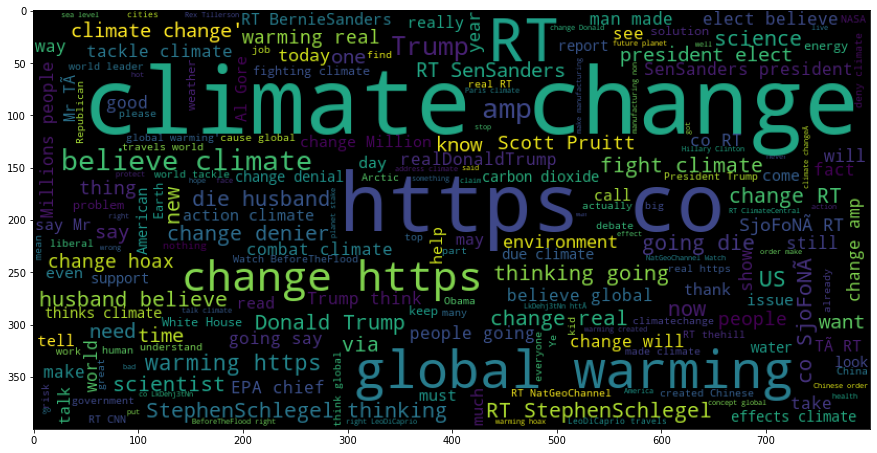

In [96]:
from wordcloud import WordCloud 
allwords = ' '.join( [tweets for tweets in train['message']])
wordCloud = WordCloud(width=800, height=400,random_state=42).generate(allwords)
plt.figure( figsize=(15,10) )
plt.imshow(wordCloud)

## Insights from EDA

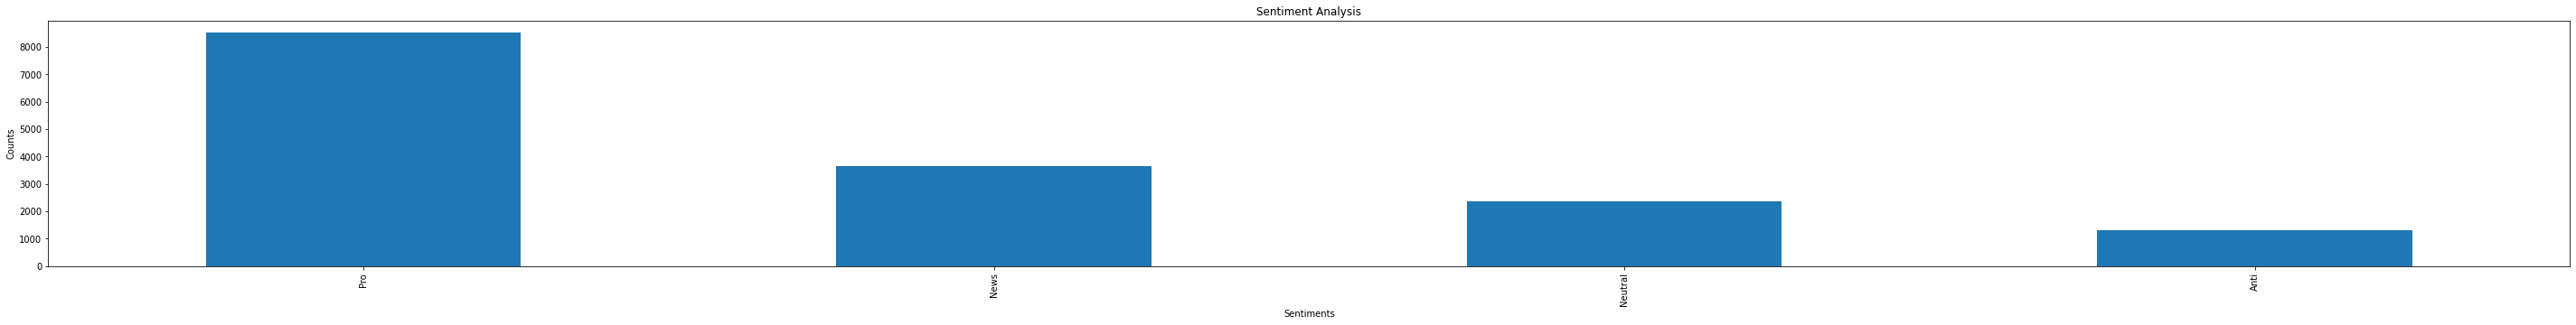

In [97]:
#Show the counts
df_train['Analysis'].value_counts()

#plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
df_train['Analysis'].value_counts().plot(kind='bar')
plt.show()

It is clear that from the above plot that our data consist of more tweets that are for climate change, with the anti sentiment 
having the least number of data points,this may result in our model being biased towards **Pro** tweets.

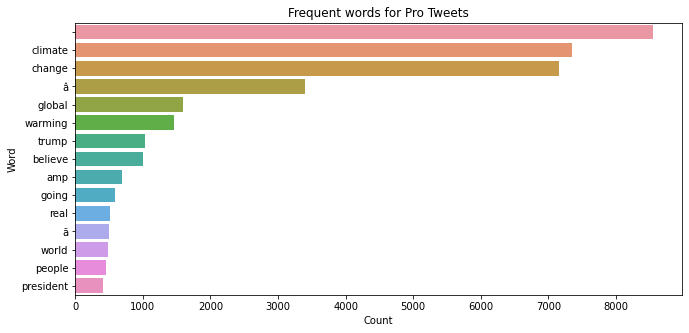

In [98]:
pro = ' '.join([word for word in df_train['no_stopwords'][df_train['Analysis'] == 'Pro']])
plt.rcParams['figure.figsize'] = [50, 5]
plt.subplot(1, 4, 2)
f = nltk.FreqDist(pro.split(' '))
df = pd.DataFrame({'Word': list(f.keys()),'Count' : list(f.values())})
df = df.nlargest(columns='Count', n=15)
ax = sns.barplot(data=df, y='Word', x='Count')
plt.title('Frequent words for Pro Tweets')
plt.show()

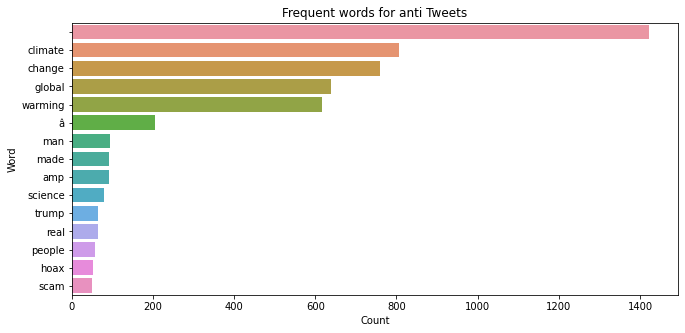

In [99]:
anti = ' '.join([word for word in df_train['no_stopwords'][df_train['Analysis'] == 'Anti']])
plt.rcParams['figure.figsize'] = [50, 5]
plt.subplot(1, 4, 4)
f = nltk.FreqDist(anti.split(' '))
df = pd.DataFrame({'Word': list(f.keys()),'Count' : list(f.values())})
df = df.nlargest(columns='Count', n=15)
ax = sns.barplot(data=df, y='Word', x='Count')
plt.title('Frequent words for anti Tweets')
plt.show()

# **Model Selection for the raw unprocessed data**

We performed model selection the raw data and the proceesed data because the models seemed to perform much better on the raw data than the processed data.

In [100]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [32]:
#Copy the unprocessed train and test dataframes
X = train['message'] 
y = train['sentiment']

## Vectorize Words

Word vectorization is the proccess of getting features from words. This is turning text into features our models can read. 

We can use either Count vectorizer or Tfid vectorizer.

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X = vectorizer.fit_transform(train['message'])

## Splitting Data into Training and Testing sets

most of the data is used for training, and a smaller portion of the data is used for testing. Analysis Services randomly samples the data to help ensure that the testing and training sets are similar.

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

**Logistic regression** - is a predictive analysis used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables

In [103]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

# Form a prediction set
predictions_lr = lr.predict(X_val)

# Print a classification report
print(classification_report(y_val, predictions_lr))

logistic_acc = accuracy_score (predictions_lr,y_val)


logistic_prec = precision_score (y_val,predictions_lr ,average='macro',)


logistic_rec = recall_score (y_val,predictions_lr ,average='weighted',)


logistic_f_score = f1_score (y_val,predictions_lr ,average='weighted',)

# Print the overall accuracy
print('The Logistic regression achieved an accuracy of '+ str(round(accuracy_score(y_val,predictions_lr)*100))+'% with its default unturned parameters')

              precision    recall  f1-score   support

          -1       0.87      0.24      0.38       428
           0       0.69      0.31      0.43       737
           1       0.71      0.93      0.81      2861
           2       0.80      0.70      0.75      1195

    accuracy                           0.73      5221
   macro avg       0.77      0.55      0.59      5221
weighted avg       0.74      0.73      0.70      5221

The Logistic regression achieved an accuracy of 73% with its default unturned parameters


# Linear SVC algorithm


**Support Vector Machines** are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of **two categories**, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. 

Note that the model generates a confidence score which is higher than Logistics Regression model.

**Linear SVC algorithm** - it fits to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the "predicted" class is.

In [107]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

# Form a prediction set
predictions_lsvc = lsvc.predict(X_val)


metrics5 = classification_report(y_val, predictions_lsvc)

confusion4 = confusion_matrix(y_val, predictions_lsvc)

#experiment.log_confusion_matrix(labels=["News", "Pro", "Neutral","Anti"],matrix=confusion4)

# Print a classification report
print(classification_report(y_val, predictions_lsvc))

Linear_acc = accuracy_score (predictions_lsvc,y_val)


Linear_prec = precision_score (y_val,predictions_lsvc ,average='macro',)


Linear_rec = recall_score (y_val,predictions_lsvc ,average='weighted',)


Linear_f_score = f1_score (y_val,predictions_lsvc ,average='weighted',)


# Print the overall accuracy

print('The Linear SVC algorithm achieved an accuracy of '+ str(round(accuracy_score(y_val,predictions_lsvc)*100))+'% with its default unturned parameters')

              precision    recall  f1-score   support

          -1       0.78      0.47      0.59       428
           0       0.58      0.43      0.50       737
           1       0.77      0.87      0.81      2861
           2       0.76      0.75      0.76      1195

    accuracy                           0.75      5221
   macro avg       0.72      0.63      0.66      5221
weighted avg       0.74      0.75      0.74      5221

The Linear SVC algorithm achieved an accuracy of 75% with its default unturned parameters


In [40]:
f1_score(y_val,predictions_lsvc,average='macro')

0.6639089055005203

In [42]:
test_df.head()

,message,tweetid,tokens,no_stopwords,stems,lemmas
0,europe will now be looking to china to make su...,169760,"[europe, will, now, be, looking, to, china, to...","[europe, looking, china, make, sure, alone, fi...","[europ, look, china, make, sure, alon, fight, ...","[europe, looking, china, make, sure, alone, fi..."
1,combine this with the polling of staffers re c...,35326,"[combine, this, with, the, polling, of, staffe...","[combine, polling, staffers, climate, change, ...","[combin, poll, staffer, climat, chang, women, ...","[combine, polling, staffer, climate, change, w..."
2,"the scary, unimpeachable evidence that climate...",224985,"[the, scary, unimpeachable, evidence, that, cl...","[scary, unimpeachable, evidence, climate, chan...","[scari, unimpeach, evid, climat, chang, alread...","[scary, unimpeachable, evidence, climate, chan..."
3,\nputin got to you too jill ! \ntrump does...,476263,"[, putin, got, to, you, too, jill, trump, does...","[, putin, got, jill, trump, believe, climate, ...","[, putin, got, jill, trump, believ, climat, ch...","[, putin, got, jill, trump, believe, climate, ..."
4,'female orgasms cause global warming!'\n-sarca...,872928,"[, female, orgasms, cause, global, warming, sa...","[, female, orgasms, cause, global, warming, sa...","[, femal, orgasm, caus, global, warm, sarcast,...","[, female, orgasm, cause, global, warming, sar..."


# **Submission File**

In [108]:
# getting our test set ready
X_test= test['message']
test_vect = vectorizer.transform(X_test)

# Making predictions on the datase and adding a sentiment column to our original test_df
#test_df['sentiment'] = lr.predict(X_test)

#creating an output csv for submission
#test_df[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)

In [109]:
y_pred = lsvc.predict(test_vect)

In [110]:
test['sentiment'] = y_pred

In [111]:
test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,1
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,0


In [112]:
test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)